In [2]:
import pandas as pd
import datetime as dt
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import numpy as np
from uszipcode import SearchEngine
import seaborn as sns
import pickle
%matplotlib inline

# Load the Data

In [3]:
df = pd.read_csv("data/assessments.csv",low_memory=False)
pd.set_option('display.max_rows', 200)

# Check Missing Data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582137 entries, 0 to 582136
Data columns (total 86 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   PARID                 582137 non-null  object 
 1   PROPERTYHOUSENUM      582137 non-null  int64  
 2   PROPERTYFRACTION      582137 non-null  object 
 3   PROPERTYADDRESS       582137 non-null  object 
 4   PROPERTYCITY          582134 non-null  object 
 5   PROPERTYSTATE         582137 non-null  object 
 6   PROPERTYUNIT          582137 non-null  object 
 7   PROPERTYZIP           582135 non-null  float64
 8   MUNICODE              582137 non-null  int64  
 9   MUNIDESC              582137 non-null  object 
 10  SCHOOLCODE            582137 non-null  int64  
 11  SCHOOLDESC            582137 non-null  object 
 12  LEGAL1                582114 non-null  object 
 13  LEGAL2                518103 non-null  object 
 14  LEGAL3                337625 non-null  object 
 15  

In [5]:
n_null = df.isnull().sum().sort_values(ascending=False)
n_null

FARMSTEADFLAG           582130
ABATEMENTFLAG           581557
TAXSUBCODE              580426
TAXSUBCODE_DESC         580426
CLEANGREEN              580314
ALT_ID                  555966
PREVSALEPRICE2          364848
PREVSALEDATE2           364221
HOMESTEADFLAG           279646
LEGAL3                  244512
RECORDDATE              217822
PREVSALEPRICE           191435
PREVSALEDATE            189656
FIREPLACES              171631
BSMTGARAGE              156592
HALFBATHS               139063
ROOFDESC                135751
ROOF                    135751
HEATINGCOOLING          135198
HEATINGCOOLINGDESC      135198
FULLBATHS               135129
BASEMENTDESC            135115
BASEMENT                135115
TOTALROOMS              135094
CDUDESC                 135087
CDU                     135087
CONDITIONDESC           135086
CONDITION               135086
BEDROOMS                135054
EXTFINISH_DESC          135030
EXTERIORFINISH          135030
STORIES                 135025
GRADE   

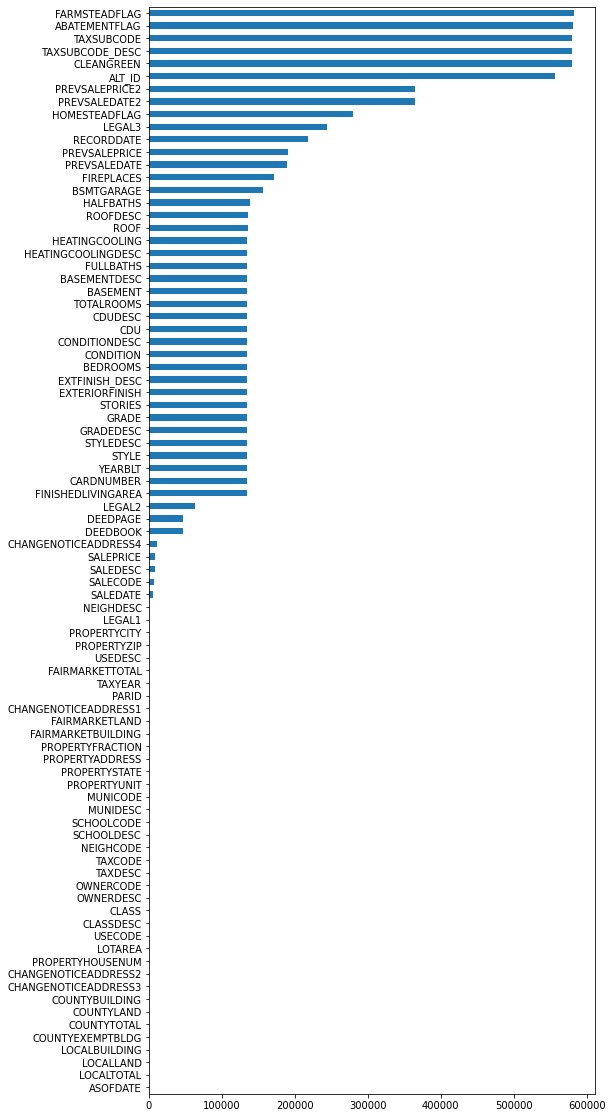

In [6]:
ax =n_null.plot(kind='barh', figsize=(8,20))
ax.invert_yaxis()

In [7]:
#drop if everything is nan
#drop target contains nan and important features that contain nan
# the zipcode information contains a typo at row 142359
df1 = df.copy()
df1 = df1.dropna(how='all')
df1 = df1.dropna(subset=['SALEPRICE', 'SALEDATE','PROPERTYCITY','PROPERTYZIP'])
df1 = df1.reset_index(drop=True)
df1.at[142359,'PROPERTYZIP'] =  15017.
df1['year'] = df1['SALEDATE'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y').year)
df1['month'] = df1['SALEDATE'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y').month)
df1['PROPERTYZIP'] = df1['PROPERTYZIP'].astype('int')
df1['PROPERTYZIP'] = df1['PROPERTYZIP'].astype('str')


In [8]:
def get_location(df):
    engine = SearchEngine()
    zipcode_dict = {}
    for zipcode in df['PROPERTYZIP'].unique():
        try:
            zc = engine.by_zipcode(zipcode)
            zipcode_dict[zipcode] = [zc.lng, zc.lat]
        except:
            print(zipcode)
            zipcode_dict[zipcode] = [np.nan, np.nan]
    return zipcode_dict

In [9]:
def school_map(df):
    school_ranking = ['North Allegheny', 'Mt Lebanon','Fox Chapel Area','Upper St Clair','South Fayette Twp','Hampton Township','Quaker Valley',
                    'Montour','Pine-Richland','Moon Area','North Hills','Plum Boro','Bethel Park','Riverview','West Jefferson Hills',
                    'Keystone Oaks','Elizabeth Forward','Baldwin Whitehall','Gateway','West Allegheny','South Park','Avonworth','Shaler Area',
                    'Chartiers Valley','Northgate', 'Deer Lakes','Brentwood Boro','Pittsburgh', 'Woodland Hills', 'Steel Valley','Carlynton', 
                    'McKeesport Area','West Mifflin Area','Penn Hills Twp', 'Cornell','Highlands','East Allegheny', 'Clairton City',
                    'Allegheny Valley', 'Sto-Rox', 'South Allegheny','Wilkinsburg Boro']
    ranking = [x for x in range(1,len(school_ranking)+1)]
    ranking_dict = dict(zip(school_ranking, ranking))
    school_missing = [x for x in df.SCHOOLDESC.unique() if x not in school_ranking]
    missing_map = {}
    for zc in df.PROPERTYZIP.unique():
        schools = list(df[df['PROPERTYZIP']==zc]['SCHOOLDESC'].unique())
        for s in schools:
            if s in school_missing:
                if s not in missing_map:
                    missing_map[s] = schools
                    missing_map[s].remove(s)
                else:
                    missing_map[s] += schools
                    missing_map[s].remove(s)
    for key in missing_map:
        missing_map[key] = np.array(list(map(ranking_dict.get, missing_map[key]))).mean()
        school_ranking_dict = dict(zip(list(missing_map.keys())+list(ranking_dict.keys()),list(missing_map.values())+list(ranking_dict.values())))
    return dict(zip(list(missing_map.keys())+list(ranking_dict.keys()),list(missing_map.values())+list(ranking_dict.values())))


In [10]:
# map zip code to longitude and latitude
# map school district to ranking number
zipcode_dict = get_location(df1)
school_ranking_dict= school_map(df1)

In [11]:
class Features_Transformer(object):
    """Class that transform categorical features into numeric features and fill the missing data.
    
    Data cleaning process of trasform original features to numeric features.
    Dummy transform is at the end of the process.
    
    Attributes:
        zipcode_dict: hash map between zip code and longitude, latitude
        school_ranking_dict:  hash map between school district and ranking
    """
    
    def __init__(self, zipcode_dict, school_ranking_dict): 
        
        """Inits Features_Transformer"""
        
        self.zipcode_dict = zipcode_dict
        self.school_ranking_dict = school_ranking_dict 
        
        # ranking list to transform categorical features with ranking
        self.grade_ranking_list = ['XX+','XX','XX-','X+','X','X-','A+','A','A-','B+','B','B-',
                                   'C+','C','C-','D+','D','D-','E+','E','E-']
        self.CDU_ranking_list = ['EXCELLENT', 'VERY GOOD', 'GOOD','AVERAGE','FAIR', 'POOR',
                                 'VERY POOR','UNSOUND']
        
        self.feature_location = []
        self.feature_mean = []
        # 
        self.cat_features = ['TAXDESC','TAXSUBCODE_DESC','OWNERDESC','CLASSDESC','SALEDESC', 
                             'STYLEDESC','EXTFINISH_DESC','ROOFDESC','BASEMENTDESC',
                             'HEATINGCOOLINGDESC']
        self.missing_numeric_features = ['FIREPLACES', 'BSMTGARAGE', 'HALFBATHS', 'ROOF', 
                                         'FULLBATHS', 'BASEMENT', 'TOTALROOMS', 'CONDITION', 
                                         'BEDROOMS', 'EXTERIORFINISH', 'STORIES', 
                                         'FINISHEDLIVINGAREA', 'CARDNUMBER', 'YEARBLT' ]
        self.additional_feature = ['MUNICODE', 'SCHOOLCODE', 'OWNERCODE', 'USECODE', 'LOTAREA', 
                                   'COUNTYBUILDING', 'COUNTYLAND', 'COUNTYTOTAL', 'COUNTYEXEMPTBLDG', 
                                   'LOCALBUILDING', 'LOCALLAND', 'LOCALTOTAL', 'FAIRMARKETBUILDING', 
                                   'FAIRMARKETLAND', 'FAIRMARKETTOTAL']

        self.dummy_features = ['TAXDESC','TAXSUBCODE_DESC', 'OWNERDESC', 'CLASSDESC', 'SALEDESC', 
                               'STYLEDESC','EXTFINISH_DESC','ROOFDESC','BASEMENTDESC',
                               'HEATINGCOOLINGDESC']

    
    def fit(self, X, y=None):
        """fit the features"""
        
        df = pd.DataFrame()
        
        # combine the address
        df['PROPERTYHOUSENUM'] = X['PROPERTYHOUSENUM'].astype('str')
        df['PROPERTYADDRESS'] = X['PROPERTYADDRESS']
        df['PROPERTYCITY'] = X['PROPERTYCITY']
        df['PROPERTYSTATE'] = X['PROPERTYSTATE']
        df['PROPERTYZIP'] = X['PROPERTYZIP'].astype('int')
        df['PROPERTYZIP'] = df['PROPERTYZIP'].astype('str')
        df['address'] = df[['PROPERTYHOUSENUM','PROPERTYADDRESS','PROPERTYCITY','PROPERTYSTATE','PROPERTYZIP']].agg(' '.join, axis=1)
        
        # drop useless features after getting the address
        df = df.drop(columns=['PROPERTYHOUSENUM', 'PROPERTYADDRESS', 'PROPERTYCITY','PROPERTYSTATE'])
        
        # fill the missing date with the later one
        df['PREVSALEDATE'] = X['PREVSALEDATE'].fillna(X['SALEDATE'])
        df['PREVSALEDATE2'] = X['PREVSALEDATE2'].fillna(df['PREVSALEDATE'])
        
        # fill the missing dale price with the later one
        df['SALEPRICE'] = X['SALEPRICE']
        df['PREVSALEPRICE'] = X['PREVSALEPRICE'].fillna(X['SALEPRICE'])
        df['PREVSALEPRICE2'] = X['PREVSALEPRICE2'].fillna(df['PREVSALEPRICE'])
         
        # change date features to datetime object
        df['SALEDATE'] = X['SALEDATE'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y'))
        df['PREVSALEDATE'] = df['PREVSALEDATE'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y'))
        df['PREVSALEDATE2'] = df['PREVSALEDATE2'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y'))
        
        # adding timestamp from datetime object
        df['Timestamp0'] = df['SALEDATE'].apply(lambda x: x.timestamp())
        df['Timestamp1'] = df['PREVSALEDATE'].apply(lambda x: x.timestamp())
        df['Timestamp2'] = df['PREVSALEDATE2'].apply(lambda x: x.timestamp())
        
        # drop datetime object
        df = df.drop(columns=['SALEDATE', 'PREVSALEDATE','PREVSALEDATE2'])
        
        # map the school ranking hashmap to school disctrict
        df['SCHOOL_Ranking'] = X['SCHOOLDESC'].map(school_ranking_dict)
        
        # change binary categorical features to 0 and 1
        # missing value is 0
        df['HOMESTEADFLAG'] = X['HOMESTEADFLAG'].notnull().astype('int')
        df['FARMSTEADFLAG'] = X['FARMSTEADFLAG'].notnull().astype('int')
        df['CLEANGREEN'] = X['CLEANGREEN'].notnull().astype('int')
        df['ABATEMENTFLAG'] = X['ABATEMENTFLAG'].notnull().astype('int')
        
        # map the zip code to longitude, latitude 
        # get the locations to fill other features' missing values
        df['longitude'] = df['PROPERTYZIP'].apply(lambda x: zipcode_dict[x][0])
        df['latitude'] = df['PROPERTYZIP'].apply(lambda x: zipcode_dict[x][1])
        df['location']=list(zip(df['longitude'], df['latitude']))
        
        # map GRADE features with ranking
        # fill missing values with location information
        # if anything else is missing, fill it with the mean
        df['GRADE'] = X['GRADE'].map(dict(zip(self.grade_ranking_list, range(1,len(self.grade_ranking_list)+1))))
        self.grade_mean = df['GRADE'].mean()
        self.grade_location =df['location'].map(df[['location','GRADE']].dropna().groupby('location').mean().to_dict()['GRADE'])
        df['GRADE'] = df['GRADE'].fillna(self.grade_location)
        df['GRADE'] = df['GRADE'].fillna(self.grade_mean)
        
        # map CDU features with ranking
        # fill missing values with location information
        # if anything else is missing, fill it with the mean
        df['CDUDESC'] = X['CDUDESC'].map(dict(zip(self.CDU_ranking_list, range(1,len(self.CDU_ranking_list)+1))))
        self.CDU_mean = df['CDUDESC'].mean()
        self.CDU_location = df['location'].map(df[['location','CDUDESC']].dropna().groupby('location').mean().to_dict()['CDUDESC'])
        df['CDUDESC'] = df['CDUDESC'].fillna(self.CDU_location)
        df['CDUDESC'] = df['CDUDESC'].fillna(self.CDU_mean)
        
        # replace None values with NaN in cat_features,
        # prepare for dummy transform
        for feature in self.cat_features:
            df[feature] = X[feature].replace('None',np.nan)
        
        # replace special None values with NaN
        # prepare for dummy transform
        df['CLASSDESC'] = X['CLASSDESC'].replace('OTHER','CLASS_OTHER')
        df['SALEDESC'] = X['SALEDESC'].replace('OTHER','SALE_OTHER')
        df['STYLEDESC'] = X['STYLEDESC'].replace('OTHER','STYLE_OTHER')
        df['HEATINGCOOLINGDESC'] = X['HEATINGCOOLINGDESC'].replace('Other','HEATINGCOOLING_OTHER')
    
        # fill missing values in numeric features with location information
        for i, feature in enumerate(self.missing_numeric_features):
            df[feature] = X[feature]
            self.feature_location.append(df['location'].map(df[['location',feature]].dropna().groupby('location').mean().to_dict()[feature]))
            self.feature_mean.append(df[feature].mean())
            df[feature] = df[feature].fillna(self.feature_location[i])
            df[feature] = df[feature].fillna(self.feature_mean[i])
            if feature != 'FINISHEDLIVINGAREA':
                df[feature] = df[feature].astype('int')
        
        # drop useless features        
        df = df.drop(columns=['location','PROPERTYZIP','address'])
        
        # merge current features with additional_features
        df = pd.concat([df,X[self.additional_feature]],axis=1)
              
        # transform dummy_features using get_dummies
        df_dummy = pd.get_dummies(df[self.dummy_features])
        
        # drop original dummy_features and combine current features with dummy features
        df = df.drop(columns=self.dummy_features)
        df = pd.concat([df,df_dummy],axis=1)

    def transform(self, X, y=None):
        """transform the features"""
        
        df = pd.DataFrame()
        df['PROPERTYHOUSENUM'] = X['PROPERTYHOUSENUM'].astype('str')
        df['PROPERTYADDRESS'] = X['PROPERTYADDRESS']
        df['PROPERTYCITY'] = X['PROPERTYCITY']
        df['PROPERTYSTATE'] = X['PROPERTYSTATE']
        df['PROPERTYZIP'] = X['PROPERTYZIP'].astype('int')
        df['PROPERTYZIP'] = df['PROPERTYZIP'].astype('str')
        
        df['address'] = df[['PROPERTYHOUSENUM','PROPERTYADDRESS','PROPERTYCITY','PROPERTYSTATE','PROPERTYZIP']].agg(' '.join, axis=1)
        df = df.drop(columns=['PROPERTYHOUSENUM', 'PROPERTYADDRESS', 'PROPERTYCITY','PROPERTYSTATE'])
        
        df['PREVSALEDATE'] = X['PREVSALEDATE'].fillna(X['SALEDATE'])
        df['PREVSALEDATE2'] = X['PREVSALEDATE2'].fillna(df['PREVSALEDATE'])
        
        df['SALEPRICE'] = X['SALEPRICE']
        df['PREVSALEPRICE'] = X['PREVSALEPRICE'].fillna(X['SALEPRICE'])
        df['PREVSALEPRICE2'] = X['PREVSALEPRICE2'].fillna(df['PREVSALEPRICE'])
        
        df['SALEDATE'] = X['SALEDATE'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y'))
        df['PREVSALEDATE'] = df['PREVSALEDATE'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y'))
        df['PREVSALEDATE2'] = df['PREVSALEDATE2'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y'))
        
        #df['Timestamp0'] = df['SALEDATE'].values.astype(np.int64) // 10 ** 9
        #df['Timestamp1'] = df['PREVSALEDATE'].values.astype(np.int64) // 10 ** 9
        #df['Timestamp2'] = df['PREVSALEDATE2'].values.astype(np.int64) // 10 ** 9
        df['Timestamp0'] = df['SALEDATE'].apply(lambda x: x.timestamp())
        df['Timestamp1'] = df['PREVSALEDATE'].apply(lambda x: x.timestamp())
        df['Timestamp2'] = df['PREVSALEDATE2'].apply(lambda x: x.timestamp())
        
        df = df.drop(columns=['SALEDATE', 'PREVSALEDATE','PREVSALEDATE2'])
        
        df['SCHOOL_Ranking'] = X['SCHOOLDESC'].map(school_ranking_dict)
        
        df['HOMESTEADFLAG'] = X['HOMESTEADFLAG'].notnull().astype('int')
        df['FARMSTEADFLAG'] = X['FARMSTEADFLAG'].notnull().astype('int')
        df['CLEANGREEN'] = X['CLEANGREEN'].notnull().astype('int')
        df['ABATEMENTFLAG'] = X['ABATEMENTFLAG'].notnull().astype('int')
        
        df['longitude'] = df['PROPERTYZIP'].apply(lambda x: zipcode_dict[x][0])
        df['latitude'] = df['PROPERTYZIP'].apply(lambda x: zipcode_dict[x][1])
        df['location']=list(zip(df['longitude'], df['latitude']))
        
        df['GRADE'] = X['GRADE'].map(dict(zip(self.grade_ranking_list, range(1,len(self.grade_ranking_list)+1))))
        df['GRADE'] = df['GRADE'].fillna(self.grade_location)
        df['GRADE'] = df['GRADE'].fillna(self.grade_mean)
    
        df['CDUDESC'] = X['CDUDESC'].map(dict(zip(self.CDU_ranking_list, range(1,len(self.CDU_ranking_list)+1))))
        df['CDUDESC'] = df['CDUDESC'].fillna(self.CDU_location)
        df['CDUDESC'] = df['CDUDESC'].fillna(self.CDU_mean)
        
        for feature in self.cat_features:
            df[feature] = X[feature].replace('None',np.nan)
            
        df['CLASSDESC'] = X['CLASSDESC'].replace('OTHER','CLASS_OTHER')
        df['SALEDESC'] = X['SALEDESC'].replace('OTHER','SALE_OTHER')
        df['STYLEDESC'] = X['STYLEDESC'].replace('OTHER','STYLE_OTHER')
        df['HEATINGCOOLINGDESC'] = X['HEATINGCOOLINGDESC'].replace('Other','HEATINGCOOLING_OTHER')
        
        for i, feature in enumerate(self.missing_numeric_features):
            df[feature] = X[feature]
            df[feature] = df[feature].fillna(self.feature_location[i])
            df[feature] = df[feature].fillna(self.feature_mean[i])
            if feature != 'FINISHEDLIVINGAREA':
                df[feature] = df[feature].astype('int')
                
        df = df.drop(columns=['location','PROPERTYZIP','address'])
        
        df = pd.concat([df,X[self.additional_feature]],axis=1)
        
        df_dummy = pd.get_dummies(df[self.dummy_features])
        df = df.drop(columns=self.dummy_features)
        df = pd.concat([df,df_dummy],axis=1)
       
        return df
    
    def fit_transform(self, X, y=None):
        """fit and transform the features"""
        self.fit(X)
        return self.transform(X)

In [12]:
# remove large amount of 0 or near 0 housing price
df1 = df1[df1.SALEPRICE>10].reset_index(drop = True)
ftf = Features_Transformer(zipcode_dict, school_ranking_dict)
df2 = ftf.fit_transform(df1)

In [13]:
pickle.dump(df2, open("data/cleaned_data.pkl", "wb"))